# Example 2 - SHO

## Finding numerical solutions for differential equations

In this notebook, we will study how we can apply deep neural networks to reproduce the behavior of known functions. For training, we will use a loss function that is exactly the differential equation (and not a comparison with existing data). This method is usually called PINN (*Physics Inspired Neural Networks*). Thus, the neural network itself is trained to be a function that behaves like the solution of the differential equation.

Importing libraries for visualization, numerical calculations, and neural networks.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch as tc

from torch import nn

Declaring our network in PyTorch

In [2]:
class SineActivation(nn.Module):
    """
    SineActivation: This is a module that inherits from nn.Module, creating a custom activation function based on PyTorch's sine function (tc.sin). 
    When applied to a tensor, this function returns the sine of each element in the tensor.
    """
    def __init__(self): 
        super(SineActivation, self).__init__() 
    def forward(self, x):
        return tc.sin(x)
    
class NeuralNetwork(nn.Module):

    def __init__(self, neurons, M, output=1, activation=None):
        """
        Attributes:
            neurons: Defines the number of neurons in each hidden layer.
            M: Number of hidden layers.
            output: Number of neurons in the output layer.
            activation: The activation function for the hidden layers.
        """
        super().__init__()
        self.neurons = neurons
        self.M = M
        self.output = output

        # List to store the linear layers
        self.hidden_layers = nn.ModuleList([nn.Linear(1, neurons)])
        self.hidden_layers.extend([nn.Linear(neurons, neurons) for _ in range(M-1)])
        
        # Last linear layer
        self.output_layer = nn.Linear(neurons, output)

        # Activation function
        self.activation = activation

    def forward(self, x):
        for layer in self.hidden_layers:
            x = self.activation(layer(x))
        x = self.output_layer(x)
        return x


Network structure:

Starts with a linear layer that transforms the input to the `neurons` dimension.
Adds M-1 hidden layers, all with `neurons` dimension.
Ends with a linear output layer that transforms the last hidden layer to the defined output dimension.

Forward method:

Processes the input data through the hidden layers, applying the specified activation function after each linear layer, except in the output layer, where it only applies the linear transformation.
If `create_graph` below is `True`, an additional parameter `acceleration` is added as a trainable attribute of the class, which can be used to adjust the model's response during training.


# Simple Harmonic Oscillator

$$

\frac{{d^2\theta}}{{dt^2}} + \omega_0^2 \theta =0

$$

$ \omega_0 = \sqrt{g/l}$ é a frequencia de oscilação em termo de g = gravidade da mola e l=comprimento do pendulo. 

Solução considerando $ \omega(0)=0$ e $ \theta(0)=\theta_0$:


$$
\theta(t) = \theta_0cos(w_0t) 
$$

Creating a function that represents our analytical solution.

In [3]:
def analytical_solution_SHO(x_0, omega_0, t):
    x_0_ = tc.tensor(x_0)
    return x_0_ * tc.cos(tc.tensor(omega_0) * t)

Let's define some parameters

In [4]:
x_0 = np.pi/4  # Initial condition
t_i = 0        # Initial time
t_f = 2        # Final time
Omega_0 = np.sqrt(9.8/0.5)  # Oscillation frequency
print(Omega_0)

4.427188724235731


In [5]:
# Set a random seed
tc.manual_seed(42)

# Creating training data
t_train = tc.linspace(t_i, t_f, 50, requires_grad=True).reshape(-1, 1)  # Time.
theta_train = analytical_solution_SHO(x_0=x_0, omega_0=Omega_0, t=t_train)  # Analytical solution of SHO.

icx = tc.tensor([x_0])  # Initial condition of position.
icv = tc.tensor([0])    # Initial condition of velocity.

model = NeuralNetwork(neurons=10, M=2, output=1, activation=SineActivation())  # Defining the neural network
opt = tc.optim.Adam(params=model.parameters(), lr=0.01)  # Defining the optimizer
step_lr = tc.optim.lr_scheduler.StepLR(opt, gamma=0.9, step_size=250)


Visualizing the expected result

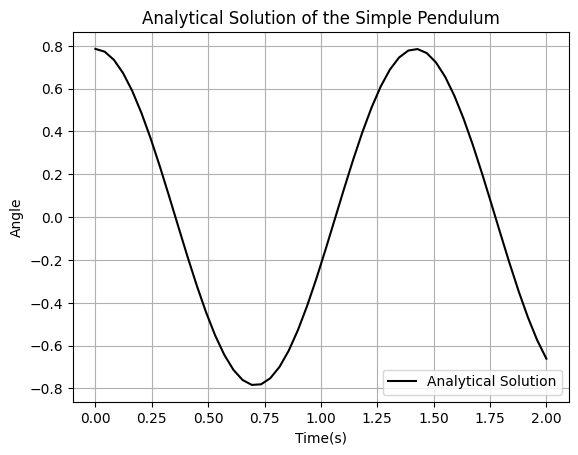

In [6]:
plt.plot(t_train.detach().numpy(), theta_train.detach().numpy(), "k-", label="Analytical Solution")

# Adding labels and title
plt.ylabel("Angle")
plt.xlabel("Time(s)")
plt.title("Analytical Solution of the Simple Pendulum")
plt.legend()
plt.grid(True)
plt.show()

### Training our network

Let's train the network using PyTorch autograd. That is, we do not calculate the derivatives analytically, but obtain them through automatic differentiation (a symbolic technique of the network). See the part of the code between the hashes. We are simply asking that the found derivatives respect the differential equation and the given parameters. Since the ODE itself is such that it equals 0, we can square it to obtain a convex cost function and minimize it.

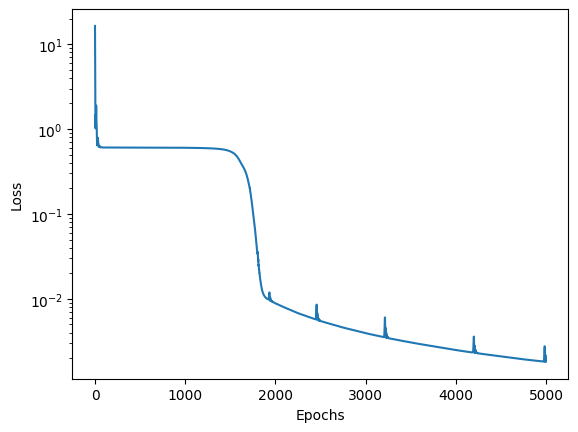

In [7]:
LOSS = []
for epoch in range(5000):
    y_preds = model(t_train)
    solution_theta = y_preds.reshape(-1,1)

    ###########################################################################
    d_theta_dt = tc.autograd.grad(solution_theta,
                                    t_train, 
                                    grad_outputs = tc.ones_like(solution_theta),
                                    create_graph = True)[0]
    d_omega_dt = tc.autograd.grad(d_theta_dt,
                                    t_train, 
                                    grad_outputs = tc.ones_like(d_theta_dt),
                                    create_graph=True)[0]

    # ODE
    loss_ode_dvdt = tc.mean( (d_omega_dt + Omega_0**2*solution_theta )**2 )

    # Initial condition for x0
    loss_icx = (solution_theta[0] - icx)**2

    # Initial condition for v0
    loss_icv = (d_theta_dt[0] - icv)**2 

    loss = loss_ode_dvdt + loss_icx + loss_icv
    ############################################################################

    opt.zero_grad()
    loss.backward(retain_graph=True)
    opt.step()
    step_lr.step()
    
    LOSS.append(loss.cpu().detach().numpy())

plt.plot(LOSS)
plt.yscale('log')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.show()


Now we will compare the neural network solution with the analytical one

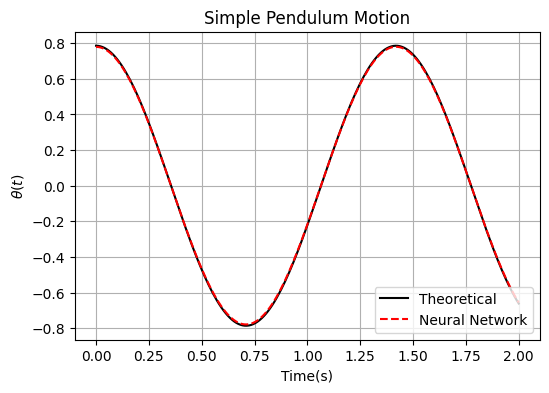

In [8]:
t_test = tc.linspace(t_i, t_f, 200, requires_grad=True).reshape(-1, 1)
y_test = analytical_solution_SHO(x_0=x_0, omega_0=Omega_0, t=t_test)

y_preds_test = model(t_test)
solution_x = y_preds_test.reshape(-1, 1)

plt.subplots(figsize=(6, 4))
plt.plot(t_test.detach().numpy(), y_test.detach().numpy(), "k-", label="Theoretical")
plt.plot(t_test.detach().numpy(), solution_x.detach().numpy(), "r--", label="Neural Network")

plt.legend()

# Adding labels and title
plt.ylabel(r"$\theta(t)$")
plt.xlabel("Time(s)")
plt.title("Simple Pendulum Motion")
plt.legend()
plt.grid(True)
plt.show()


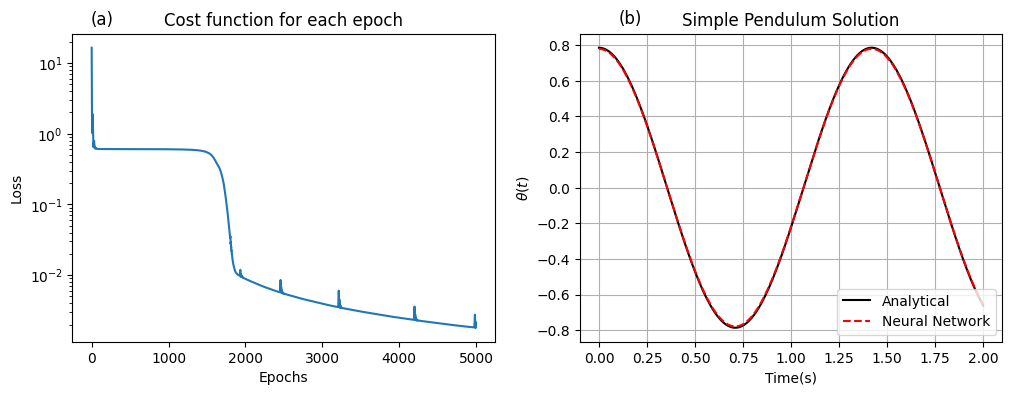

In [9]:
# Defining the figure size (width, height) in inches

plt.figure(figsize=(12, 4))  # Increase the values as needed

plt.subplot(1,2,1)
plt.text(-10,35, '(a)', fontsize=12,)
plt.plot(LOSS)
plt.yscale('log')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("Cost function for each epoch")

plt.subplot(1,2,2)
plt.text(0.1,.92, '(b)', fontsize=12,)
t_test = tc.linspace(t_i,t_f,200,requires_grad=True).reshape(-1,1)
y_test = analytical_solution_SHO(x_0 = x_0 ,omega_0 = Omega_0 ,t = t_test)

y_preds_test = model(t_test)
solution_x = y_preds_test.reshape(-1,1)
plt.plot(t_test.detach().numpy(), y_test.detach().numpy(),"k-", label="Analytical")
plt.plot(t_test.detach().numpy(), solution_x.detach().numpy(),"r--", label=f"Neural Network" )

# Adding labels and title
plt.ylabel(r"$\theta(t)$")
plt.xlabel("Time(s)")
plt.title("Simple Pendulum Solution")
plt.legend()
plt.grid()
plt.savefig("pendulumNNODE.png",dpi=500)
plt.show()
